In [1]:
import time
import psutil
import json
from datetime import datetime
try:
    import GPUtil
except ImportError:
    GPUtil = None

# this will hold all of our snapshots
_monitor = []

# mark the absolute start
_start_time = time.perf_counter()

def take_snapshot(stage: str):
    """Record timestamp, CPU, RAM, and (if available) GPU usage."""
    proc = psutil.Process()
    now = time.perf_counter()
    rec = {
        "time_s": now - _start_time,
        "stage": stage,
        "cpu_percent": psutil.cpu_percent(interval=None),
        "proc_cpu_percent": proc.cpu_percent(interval=None),
        "ram_mb": proc.memory_info().rss / (1024**2),
        "gpus": []
    }
    if GPUtil is not None:
        for g in GPUtil.getGPUs():
            rec["gpus"].append({
                "id": g.id,
                "load": g.load * 100,
                "memoryUsed_MB": g.memoryUsed
            })
    _monitor.append(rec)


In [2]:
# Importing necessary libraries
import pertpy as pt
import torch
import os
import random
import scanpy as sc
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('./')
# from scGen_class_v2 import scGenPerturbationAnalysis


from scvi import REGISTRY_KEYS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse, stats

/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
take_snapshot("start")

In [4]:
norm_data = sc.read("scgen_demo_hvg5K.h5ad")

In [5]:
# Set the target number of cells
target_cells = 2000 # this is arbitrary, change it accordingly

# Calculate the proportion to sample
sample_fraction = target_cells / norm_data.n_obs

# Perform downsampling
norm_data = norm_data[np.random.choice(norm_data.obs_names, size=target_cells, replace=False)]

In [6]:
norm_data

View of AnnData object with n_obs × n_vars = 2000 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca', 'X_umap'

In [7]:
# celltype_col = "author_cell_type"

In [8]:
n_epochs       = 25
batch_size     = 32
pca_components = 30          
ctrl_key       = "ctrl"       
stim_key       = "stim"
condition_col  = "label"
celltype_col   = "cell_type"

In [9]:
# ── reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── GPU settings ─────────────────────────────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = "0"        # pick your GPU
DEVICE_COUNT = torch.cuda.device_count()
assert DEVICE_COUNT, "No CUDA-visible device!"

In [10]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class scGenPerturbationAnalysis:
    """
    A class to perform perturbation analysis using scGen on single-cell RNA-seq data.

    This class encapsulates the full analysis pipeline from data loading and preprocessing
    to model training, prediction, and evaluation.

    Attributes:
    - data: The original AnnData object containing the dataset.
    - train_set: The training dataset after excluding specific cells.
    - scgen_model: The trained scGen model.
    - latent_adata: AnnData object containing latent representations.
    - pred: AnnData object containing predicted cells.
    - delta: The perturbation vector learned by the model.
    - eval_adata: AnnData object used for evaluating predictions.
    - diff_genes: List of differentially expressed genes.
    - r2_value: R^2 value from mean expression correlation plot.
    - r_value_diff: R value for differentially expressed genes.
    - perturbation_score: Perturbation score computed using a distance metric.
    """

    def __init__(self, data):
        """
        Initialize the scGenPerturbationAnalysis class with the input data.

        Parameters:
        - data: AnnData object containing single-cell RNA-seq data.
        """
        self.data = data.copy()
        self.train_set = None
        self.scgen_model = None
        self.latent_adata = None
        self.pred = None
        self.delta = None
        self.eval_adata = None
        self.diff_genes = None
        self.r2_value = None
        self.r_value_diff = None
        self.perturbation_score = None

    def explore_data(self, groupby_cols=None, plot_cols=None, value_count_cols=None):
        """
        Perform basic exploration of the data, including printing counts, value counts, and plotting UMAPs.

        Parameters:
        - groupby_cols: List of column names to group by for counts (default: None).
        - plot_cols: List of column names to use for UMAP coloring (default: None).
        - value_count_cols: List of column names to display value counts (default: None).
        """
        print("Exploring data...")

        # Group by specified columns to understand sample distribution
        if groupby_cols is not None:
            combined_counts = self.data.obs.groupby(groupby_cols).size()
            combined_counts_df = combined_counts.reset_index(name='counts')
            print(f"Counts by {groupby_cols}:")
            print(combined_counts_df)
            print()
        else:
            print("No groupby columns provided for counts.")
            print()

        # Display value counts for specified columns
        if value_count_cols is not None:
            for col in value_count_cols:
                if col in self.data.obs.columns:
                    print(f"Value counts for '{col}':")
                    print(self.data.obs[col].value_counts())
                    print()
                else:
                    print(f"Column '{col}' not found in data.obs.")
        else:
            print("No columns provided for value counts.")
            print()

        # Visualize UMAP embeddings colored by specified annotations
        if plot_cols is not None:
            for col in plot_cols:
                if col in self.data.obs.columns:
                    sc.pl.umap(self.data, color=col, show=True)
                else:
                    print(f"Column '{col}' not found in data.obs.")
        else:
            print("No columns provided for UMAP plotting.")
        print()

    def filter_data(self, filter_conditions=None, verify_counts=False, count_groupby_cols=None):
        """
        Filter the data based on user-defined conditions.

        Parameters:
        - filter_conditions: Dictionary where keys are column names and values are the desired values to keep.
                            Values can be single values or lists of values.
                            Example: {'disease': ['normal', 'covid19']}
        - verify_counts: Boolean indicating whether to verify the filtering by checking counts (default: False).
        - count_groupby_cols: List of column names to group by when checking counts (default: None).
                            If None and verify_counts is True, defaults to filter_conditions.keys() if filter_conditions is provided.
                            If both are None, counts will not be printed.
        """
        print("Filtering data based on user-defined conditions...")
        if filter_conditions is not None:
            query_parts = []
            for col, vals in filter_conditions.items():
                if isinstance(vals, list):
                    # If vals is a list, create an OR condition for all values
                    vals_formatted = ', '.join([f'"{val}"' for val in vals])
                    query_parts.append(f'({col} in [{vals_formatted}])')
                else:
                    # Single value condition
                    query_parts.append(f'({col} == "{vals}")')
            query = " & ".join(query_parts)
            self.data = self.data[self.data.obs.eval(query)].copy()
            print(f"Filtered data with conditions: {filter_conditions}")
            print()
        else:
            print("No filter conditions provided. Data remains unfiltered.")
            print()

        # Verify the filtering by checking counts
        if verify_counts:
            if count_groupby_cols is None:
                if filter_conditions is not None:
                    count_groupby_cols = list(filter_conditions.keys())
                else:
                    print("No groupby columns provided for counts.")
                    count_groupby_cols = []
            if count_groupby_cols:
                print("Counts after filtering:")
                print(self.data.obs.groupby(count_groupby_cols).size().reset_index(name='counts'))
                print()
            else:
                print("No columns provided for grouping counts.")
                print()

    def normalize_and_visualize(self, normalize=True, log_transform=True, target_sum=1e4, plot_cols=None):
        """
        Normalize the data and visualize UMAP embeddings.

        Parameters:
        - normalize: Whether to normalize the data (default: True).
        - log_transform: Whether to log-transform the data (default: True).
        - target_sum: Target sum for normalization (default: 1e4).
        - plot_cols: List of column names to use for UMAP coloring (default: None).
        """
        if normalize:
            print("Normalizing data...")
            sc.pp.normalize_total(self.data, target_sum=target_sum)
            print(f"Data normalized to total counts per cell with target sum {target_sum}.")
            print()
        else:
            print("Normalization skipped.")
            print()
            
        if log_transform:
            sc.pp.log1p(self.data)
            print("Data log-transformed (log1p).")
            print()
        else:
            print("Log transformation skipped.")
            print()
            
        # Visualize UMAP embedding colored by specified columns
        if plot_cols is not None:
            for col in plot_cols:
                if col in self.data.obs.columns:
                    sc.pl.umap(self.data, color=col, show=True)
                else:
                    print(f"Column '{col}' not found in data.obs.")
        else:
            print("No columns provided for UMAP plotting.")
        print()

    def preprocess_data(
        self,
        highly_variable_genes=True,
        n_top_genes=2000,
        remove_conditions=None,
        subsample_n=None
    ):
        """
        Preprocess the data for scGen, including selecting highly variable genes,
        removing specific conditions, and subsampling.

        Parameters:
        - highly_variable_genes: Whether to select highly variable genes (default: True).
        - n_top_genes: Number of top variable genes to select (default: 2000).
        - remove_conditions: Dictionary of conditions to remove.
                             Example: {'time_after_LPS': ['90m']}
        - subsample_n: Number of observations to subsample (default: None).
        """
        print("Preprocessing data for scGen...")

        if highly_variable_genes:
            sc.pp.highly_variable_genes(self.data, n_top_genes=n_top_genes)
            print(f"Selected top {n_top_genes} highly variable genes.")
            print()
        else:
            print("Selection of highly variable genes skipped.")
            print()

        if remove_conditions is not None:
            for col, values in remove_conditions.items():
                if col in self.data.obs.columns:
                    self.data = self.data[~self.data.obs[col].isin(values)].copy()
                    print(f"Removed cells where '{col}' is in {values}.")
                else:
                    print(f"Column '{col}' not found in data.obs.")
            print()
        else:
            print("No conditions provided for removal.")
            print()

        if subsample_n is not None:
            sc.pp.subsample(self.data, n_obs=subsample_n)
            print(f"Subsampled data to {subsample_n} observations.")
            print()
        else:
            print("Subsampling skipped.")
            print()

        # Keep a copy of the raw data
        self.data.raw = self.data.copy()
        print("Preprocessing completed.")
        print()

    def prepare_training_set(self, exclude_query=None):
        """
        Prepare the training set by excluding specific cells based on a custom query.

        Parameters:
        - exclude_query: A string representing the query to exclude cells.
                        Example: '(cell_type == "B_naive") & (time_after_LPS == "10h")'
        """
        print("Preparing training set by excluding specific conditions...")
        if exclude_query is not None:
            self.train_set = self.data[~self.data.obs.eval(exclude_query)].copy()
            print(f"Excluded cells where: {exclude_query}")
            print()
        else:
            self.train_set = self.data.copy()
            print("No exclusion query provided. Using full dataset as training set.")
            print()

    def setup_anndata(self, batch_key=None, labels_key=None):
        """
        Set up the AnnData object for scGen.

        Parameters:
        - batch_key: Column name in obs to use as batch key (default: None).
        - labels_key: Column name in obs to use as labels key (default: None).
        """
        print("Setting up AnnData for scGen...")
        if batch_key is None or labels_key is None:
            print("Both 'batch_key' and 'labels_key' must be provided.")
            return
        pt.tl.Scgen.setup_anndata(
            self.train_set,
            batch_key=batch_key,
            labels_key=labels_key
        )
        print(f"AnnData set up for scGen with batch_key='{batch_key}' and labels_key='{labels_key}'.")
        print()

    def train_model(
        self,
        max_epochs=20,
        batch_size=32,
        early_stopping=True,
        accelerator="cpu",
        devices="auto",
        **kwargs
    ):
        """
        Initialize and train the scGen model.

        Parameters:
        - max_epochs: Maximum number of epochs to train (default: 20).
        - batch_size: Batch size for training (default: 32).
        - early_stopping: Whether to use early stopping (default: True).
        - accelerator: Device to use for training ('cpu' or 'gpu', default: 'cpu').
        - devices: Devices to use ('auto' or specific device, default: 'auto').
        - **kwargs: Additional keyword arguments for scGen training.
        """
        print("Initializing and training scGen model...")
        # Initialize the scGen model with the training data
        self.scgen_model = pt.tl.Scgen(self.train_set)
        print("scGen model initialized.")
        print()

        # Train the scGen model with specified parameters
        self.scgen_model.train(
            max_epochs=max_epochs,
            batch_size=batch_size,
            early_stopping=early_stopping,
            accelerator=accelerator,
            devices=devices,
            **kwargs
        )
        print("scGen model trained.")
        print()

        # Save the trained model
        self.scgen_model.save("model_perturbation_prediction.pt", overwrite=True)
        print("scGen model saved to 'model_perturbation_prediction.pt'.")
        print()

    def visualize_latent_space(self, plot_cols=None):
        """
        Get the latent representation from the model and visualize using UMAP.

        Parameters:
        - plot_cols: List of column names to use for UMAP coloring (default: None).
        """
        print("Visualizing latent space...")
        # Obtain the latent representations from the trained model
        latent_X = self.scgen_model.get_latent_representation()
        # Create a new AnnData object with the latent representations
        self.latent_adata = sc.AnnData(X=latent_X, obs=self.train_set.obs.copy())
        print("Latent representations obtained.")
        print()

        # Compute the neighborhood graph and UMAP embedding
        sc.pp.neighbors(self.latent_adata)
        sc.tl.umap(self.latent_adata)
        print("UMAP embedding computed.")
        print()

        # Plot the UMAP embedding colored by specified columns
        if plot_cols is not None:
            for col in plot_cols:
                if col in self.latent_adata.obs.columns:
                    sc.pl.umap(
                        self.latent_adata,
                        color=col,
                        wspace=0.4,
                        frameon=False,
                        show=True
                    )
                else:
                    print(f"Column '{col}' not found in latent_adata.obs.")
        else:
            print("No columns provided for UMAP plotting.")
        print("Latent space visualized.")
        print()

    def make_prediction(
        self,
        ctrl_key=None,
        stim_key=None,
        celltype_to_predict=None,
        condition_col=None,
        cell_type_col=None
    ):
        """
        Predict the stimulated state of specific cell types.

        Parameters:
        - ctrl_key: The control condition key (e.g., 'nan').
        - stim_key: The stimulated condition key (e.g., '10h').
        - celltype_to_predict: The cell type to predict (e.g., 'B_naive').
        - condition_col: The column name for conditions in obs (default: None).
        - cell_type_col: The column name for cell types in obs (default: None).
        """
        print("Making predictions...")
        if None in [ctrl_key, stim_key, celltype_to_predict, condition_col, cell_type_col]:
            print("All parameters must be provided for prediction.")
            return

        # Predict the stimulated state using the trained scGen model
        self.pred, self.delta = self.scgen_model.predict(
            ctrl_key=ctrl_key,
            stim_key=stim_key,
            celltype_to_predict=celltype_to_predict
        )

        #     # Predict the stimulated state using the trained scGen model
        # # First build the AnnData slice we want to predict:
        # adata_pred = self.train_set[
        #     self.train_set.obs[cell_type_col] == celltype_to_predict
        # ].copy()
        # if adata_pred.n_obs == 0:
        #     raise ValueError(
        #     f"No cells found in the training set for cell type '{celltype_to_predict}'"
        #     )

        # # Now call predict with that adata
        # self.pred, self.delta = self.scgen_model.predict(
        #     ctrl_key=ctrl_key,
        #     stim_key=stim_key,
        #     adata_to_predict=adata_pred,
        #     celltype_to_predict=celltype_to_predict
        # )





        
        # Assign a label to the predicted cells
        self.pred.obs[condition_col] = 'predicted'
        print("Predictions made.")
        print()

    def evaluate_prediction(
        self,
        condition_col=None,
        cell_type_col=None,
        control_condition=None,
        stimulated_condition=None,
        celltype_to_evaluate=None,
        pca_components=50
    ):
        """
        Evaluate the prediction by combining control, real stimulated, and predicted data.

        Parameters:
        - condition_col: The column name for conditions in obs (default: None).
        - cell_type_col: The column name for cell types in obs (default: None).
        - control_condition: The control condition key (e.g., 'nan').
        - stimulated_condition: The stimulated condition key (e.g., '10h').
        - celltype_to_evaluate: The cell type to evaluate (e.g., 'B_naive').
        - pca_components: Number of PCA components to compute (default: 50).
        """
        print("Evaluating predictions...")
        if None in [condition_col, cell_type_col, control_condition, stimulated_condition, celltype_to_evaluate]:
            print("All parameters must be provided for evaluation.")
            return

        # Extract control cells
        ctrl_adata = self.data[
            (self.data.obs[cell_type_col] == celltype_to_evaluate) &
            (self.data.obs[condition_col] == control_condition)
        ].copy()

        # Extract real stimulated cells
        stim_adata = self.data[
            (self.data.obs[cell_type_col] == celltype_to_evaluate) &
            (self.data.obs[condition_col] == stimulated_condition)
        ].copy()

        # Concatenate control, stimulated, and predicted data
        self.eval_adata = ctrl_adata.concatenate(stim_adata, self.pred)
        print("Evaluation data prepared.")
        print()

        # Perform PCA on the evaluation data
        sc.tl.pca(self.eval_adata, n_comps=pca_components)
        # Plot PCA colored by condition
        sc.pl.pca(
            self.eval_adata,
            color=condition_col,
            frameon=False,
            show=True
        )
        print("PCA plot created.")
        print()

        # Compute neighbors and UMAP for the evaluation data
        sc.pp.neighbors(self.eval_adata)
        sc.tl.umap(self.eval_adata)
        # Plot UMAP colored by condition
        sc.pl.umap(
            self.eval_adata,
            color=condition_col,
            frameon=False,
            show=True
        )
        print("UMAP plot created.")
        print()

    

    def identify_diff_genes(
        self,
        cell_type_col=None,
        condition_col=None,
        celltype_of_interest=None,
        method='wilcoxon'
    ):
        """
        Identify differentially expressed genes between control and stimulated cells.

        Parameters:
        - cell_type_col: The column name for cell types in obs (default: None).
        - condition_col: The column name for conditions in obs (default: None).
        - celltype_of_interest: The cell type to analyze (e.g., 'B_naive').
        - method: The method for differential expression (default: 'wilcoxon').
        """
        print("Identifying differentially expressed genes...")
        if None in [cell_type_col, condition_col, celltype_of_interest]:
            print("All parameters must be provided for identifying differentially expressed genes.")
            return

        # Select cells of the specified cell type
        cells_of_interest = self.data[self.data.obs[cell_type_col] == celltype_of_interest].copy()
        # Visualize UMAP of the cells
        sc.pl.umap(
            cells_of_interest,
            color=condition_col,
            frameon=False,
            show=True
        )
        print(f"UMAP of '{celltype_of_interest}' cells plotted.")
        print()

        # Perform differential expression analysis
        sc.tl.rank_genes_groups(cells_of_interest, groupby=condition_col, method=method)
        # Extract the names of differentially expressed genes
        groups = cells_of_interest.obs[condition_col].unique().tolist()
        if len(groups) >= 2:
            self.diff_genes = cells_of_interest.uns["rank_genes_groups"]["names"][groups[1]]
            print("Differentially expressed genes identified:")
            print(self.diff_genes)
        else:
            print("Not enough groups for differential expression analysis.")
        print()


    def _bootstrapped_r2(self, adata, real_key, pred_key, n_rounds: int = 100):
        """Return mean ± SD of bootstrapped R² between *pred* and *real*.

        Parameters
        ----------
        adata : AnnData
            Must contain `obs['condition']` with *real_key* and *pred_key*.
        real_key / pred_key : str
            Labels in `adata.obs['condition']`.
        n_rounds : int
            Number of bootstrap rounds (default 100).
        """
        real = adata[adata.obs["condition"] == real_key]
        pred = adata[adata.obs["condition"] == pred_key]

        # Dense matrices speed up later operations.
        X_real = real.X.toarray() if sparse.issparse(real.X) else real.X
        X_pred = pred.X.toarray() if sparse.issparse(pred.X) else pred.X

        r2_vals = np.empty(n_rounds)
        for i in range(n_rounds):
            idx_pred = np.random.choice(X_pred.shape[0], int(0.8 * X_pred.shape[0]), replace=False)
            idx_real = np.random.choice(X_real.shape[0], int(0.8 * X_real.shape[0]), replace=False)
            x_bar = X_pred[idx_pred].mean(axis=0)
            y_bar = X_real[idx_real].mean(axis=0)
            _slope, _intercept, r, _p, _stderr = stats.linregress(x_bar, y_bar)
            r2_vals[i] = r ** 2
        return r2_vals.mean(), r2_vals.std()

        # X_real = real.X.A if sparse.issparse(real.X) else real.X
        # X_pred = pred.X.A if sparse.issparse(pred.X) else pred.X

        # r2_vals = np.empty(n_rounds)
        # rng = np.random.default_rng()

        # for i in range(n_rounds):
        #     idx_pred = rng.choice(X_pred.shape[0], int(0.8 * X_pred.shape[0]), replace=False)
        #     idx_real = rng.choice(X_real.shape[0], int(0.8 * X_real.shape[0]), replace=False)
        #     x_bar = X_pred[idx_pred].mean(axis=0)
        #     y_bar = X_real[idx_real].mean(axis=0)
        #     _, _, r, _, _ = stats.linregress(x_bar, y_bar)
        #     r2_vals[i] = r ** 2
        # return float(r2_vals.mean()), float(r2_vals.std())


        


    # def plot_mean_correlation(
    #     self,
    #     condition_col=None,
    #     stimulated_condition=None,
    #     x_label='Predicted',
    #     y_label='Ground Truth',
    #     top_genes=10
    # ):
    #     """
    #     Plot mean gene expression correlation between predicted and real stimulated cells.

    #     Parameters:
    #     - condition_col: The column name for conditions in obs (default: None).
    #     - stimulated_condition: The stimulated condition key (e.g., '10h').
    #     - x_label: Label for the x-axis (default: 'Predicted').
    #     - y_label: Label for the y-axis (default: 'Ground Truth').
    #     - top_genes: Number of top differentially expressed genes to highlight (default: 10).
    #     """
    #     print("Plotting mean gene expression correlation...")
    #     if None in [condition_col, stimulated_condition]:
    #         print("Both 'condition_col' and 'stimulated_condition' must be provided.")
    #         return

    #     # Get the original condition key used in scGen
    #     condition_key = self.scgen_model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY).original_key

    #     # Plot mean expression correlation for all genes
    #     self.r2_value = self.scgen_model.plot_reg_mean_plot(
    #         self.eval_adata,
    #         condition_key=condition_key,
    #         axis_keys={"x": "predicted", "y": stimulated_condition},
    #         labels={"x": x_label, "y": y_label},
    #         path_to_save="./reg_mean.pdf",
    #         show=True,
    #         legend=False
    #     )
    #     print(f"Mean expression correlation (R^2 value): {self.r2_value}")
    #     print()

    #     # Plot mean expression correlation for top differentially expressed genes
    #     if self.diff_genes is not None:
    #         self.r2_value, self.r_value_diff = self.scgen_model.plot_reg_mean_plot(
    #             self.eval_adata,
    #             condition_key=condition_key,
    #             axis_keys={"x": "predicted", "y": stimulated_condition},
    #             gene_list=self.diff_genes[:top_genes],
    #             top_100_genes=self.diff_genes,
    #             x_coeff=0.4,
    #             y_coeff=0.75,
    #             labels={"x": x_label, "y": y_label},
    #             path_to_save="./reg_mean_diff_genes.pdf",
    #             show=True,
    #             legend=False
    #         )
    #         print(f"Mean expression correlation for top {top_genes} genes (R^2 value): {self.r2_value}")
    #         print()
    #     else:
    #         print("No differentially expressed genes available for plotting.")
    #         print()

    # New addition to capture variance in R2-------------------------------------
    def plot_mean_correlation(
        self,
        condition_col: str = None,
        stimulated_condition: str = None,
        x_label: str = "Predicted",
        y_label: str = "Ground Truth",
        top_genes: int = 10,
        n_bootstraps: int = 100,
    ):
        """Scatter of mean expression + bootstrapped R² (tutorial style).

        Stores
        -------
        self.r2_value : float
        self.r2_std   : float
        """
        if None in [condition_col, stimulated_condition]:
            print("Both 'condition_col' and 'stimulated_condition' must be provided.")
            return

        # ---- Bootstrapped R² -----------------------------------------
        adata_r2 = self.eval_adata[
            (self.eval_adata.obs[condition_col] == stimulated_condition)
            | (self.eval_adata.obs[condition_col] == "predicted")
        ].copy()
        adata_r2.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

        self.r2_value, self.r2_std = self._bootstrapped_r2(
            adata=adata_r2,
            real_key=stimulated_condition,
            pred_key="predicted",
            n_rounds=n_bootstraps,
        )


        print(f"Bootstrapped R²: {self.r2_value:.4f} ± {self.r2_std:.4f}")

        # ---- Original reg‑mean scatter (for visual parity) -----------
        cond_key = self.scgen_model.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key

        self.scgen_model.plot_reg_mean_plot(
            self.eval_adata,
            condition_key=cond_key,
            axis_keys={"x": "predicted", "y": stimulated_condition},
            gene_list=self.diff_genes[:top_genes] if self.diff_genes is not None else None,
            labels={"x": x_label, "y": y_label},
            path_to_save="./reg_mean.pdf",
            show=True,
            legend=False,
        )


    

    def compute_distance_metric(
        self,
        condition_col=None,
        control_condition=None,
        stimulated_condition=None,
        pca_components=50,
        metric='edistance'
    ):
        """
        Compute a distance metric to evaluate prediction accuracy.

        Parameters:
        - condition_col: The column name for conditions in obs (default: None).
        - control_condition: The control condition key (e.g., 'nan').
        - stimulated_condition: The stimulated condition key (e.g., '10h').
        - pca_components: Number of PCA components to compute (default: 50).
        - metric: The distance metric to use ('edistance' or 'mmd', default: 'edistance').
        """
        print("Computing distance metric...")
        if None in [condition_col, control_condition, stimulated_condition]:
            print("All parameters must be provided for computing distance metric.")
            return

        # Perform PCA on the evaluation data
        sc.tl.pca(self.eval_adata, n_comps=pca_components)
        print(f"PCA with {pca_components} components computed.")
        print()

        # Extract the subsets for real stimulated, control, and predicted data
        stim_adata2 = self.eval_adata[self.eval_adata.obs[condition_col] == stimulated_condition]
        ctrl_adata2 = self.eval_adata[self.eval_adata.obs[condition_col] == control_condition]
        pred_adata2 = self.eval_adata[self.eval_adata.obs[condition_col] == 'predicted']

        # Initialize the distance metric
        distance_metric = pt.tools.Distance(metric=metric)
        print(f"Distance metric '{metric}' initialized.")
        print()

        # Extract PCA embeddings for each subset
        pert_pca = np.array(stim_adata2.obsm["X_pca"])  # Real perturbed data
        pred_pca = np.array(pred_adata2.obsm["X_pca"])  # Simulated perturbed data
        ctrl_pca = np.array(ctrl_adata2.obsm["X_pca"])  # Control data

        # Compute the perturbation score using the distance metric
        self.perturbation_score = distance_metric.compare_distance(
            pert=pert_pca,
            pred=pred_pca,
            ctrl=ctrl_pca,
            mode="simple"
        )
        print(f"Perturbation score computed: {self.perturbation_score}")
        print()

    def run_all(self, params):
        """
        Run all steps of the analysis in sequence using provided parameters.

        Parameters:
        - params: Dictionary containing parameters for each method.
        """
        self.explore_data(
            groupby_cols=params.get('explore_data', {}).get('groupby_cols'),
            plot_cols=params.get('explore_data', {}).get('plot_cols')
        )
        self.filter_data(
            filter_conditions=params.get('filter_data', {}).get('filter_conditions')
        )
        self.normalize_and_visualize(
            normalize=params.get('normalize_and_visualize', {}).get('normalize', True),
            target_sum=params.get('normalize_and_visualize', {}).get('target_sum', 1e4),
            plot_cols=params.get('normalize_and_visualize', {}).get('plot_cols')
        )
        self.preprocess_data(
            highly_variable_genes=params.get('preprocess_data', {}).get('highly_variable_genes', True),
            n_top_genes=params.get('preprocess_data', {}).get('n_top_genes', 2000),
            remove_conditions=params.get('preprocess_data', {}).get('remove_conditions'),
            subsample_n=params.get('preprocess_data', {}).get('subsample_n')
        )
        self.prepare_training_set(
            exclude_conditions=params.get('prepare_training_set', {}).get('exclude_conditions')
        )
        self.setup_anndata(
            batch_key=params.get('setup_anndata', {}).get('batch_key'),
            labels_key=params.get('setup_anndata', {}).get('labels_key')
        )
        self.train_model(
            **params.get('train_model', {})
        )
        self.visualize_latent_space(
            plot_cols=params.get('visualize_latent_space', {}).get('plot_cols')
        )
        self.make_prediction(
            ctrl_key=params.get('make_prediction', {}).get('ctrl_key'),
            stim_key=params.get('make_prediction', {}).get('stim_key'),
            celltype_to_predict=params.get('make_prediction', {}).get('celltype_to_predict'),
            condition_col=params.get('make_prediction', {}).get('condition_col'),
            cell_type_col=params.get('make_prediction', {}).get('cell_type_col')
        )
        self.evaluate_prediction(
            condition_col=params.get('evaluate_prediction', {}).get('condition_col'),
            cell_type_col=params.get('evaluate_prediction', {}).get('cell_type_col'),
            control_condition=params.get('evaluate_prediction', {}).get('control_condition'),
            stimulated_condition=params.get('evaluate_prediction', {}).get('stimulated_condition'),
            celltype_to_evaluate=params.get('evaluate_prediction', {}).get('celltype_to_evaluate'),
            pca_components=params.get('evaluate_prediction', {}).get('pca_components', 50)
        )
        self.identify_diff_genes(
            cell_type_col=params.get('identify_diff_genes', {}).get('cell_type_col'),
            condition_col=params.get('identify_diff_genes', {}).get('condition_col'),
            celltype_of_interest=params.get('identify_diff_genes', {}).get('celltype_of_interest'),
            method=params.get('identify_diff_genes', {}).get('method', 'wilcoxon')
        )
        self.plot_mean_correlation(
            condition_col=params.get('plot_mean_correlation', {}).get('condition_col'),
            stimulated_condition=params.get('plot_mean_correlation', {}).get('stimulated_condition'),
            x_label=params.get('plot_mean_correlation', {}).get('x_label', 'Predicted'),
            y_label=params.get('plot_mean_correlation', {}).get('y_label', 'Ground Truth'),
            top_genes=params.get('plot_mean_correlation', {}).get('top_genes', 10)
        )
        self.compute_distance_metric(
            condition_col=params.get('compute_distance_metric', {}).get('condition_col'),
            control_condition=params.get('compute_distance_metric', {}).get('control_condition'),
            stimulated_condition=params.get('compute_distance_metric', {}).get('stimulated_condition'),
            pca_components=params.get('compute_distance_metric', {}).get('pca_components', 50),
            metric=params.get('compute_distance_metric', {}).get('metric', 'edistance')
        )
        print("All analysis steps completed.")

In [11]:
# import numpy as np
# import pandas as pd
# import scanpy as sc
# from scipy import sparse, stats
# from scipy.spatial.distance import cosine as cosine_dist, cdist
# from sklearn.metrics import pairwise_distances
# from sklearn.neighbors import KernelDensity
# from sklearn.decomposition import PCA

# # -----------------------------------------------------------------------------
# # 0) helpers: mean–variance KDE L1 distance, bootstrap, and scaled‐Euclidean
# # -----------------------------------------------------------------------------
# def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
#     m1, v1 = X1.mean(0), X1.var(0)
#     m2, v2 = X2.mean(0), X2.var(0)
#     pts1 = np.vstack([m1, v1]).T
#     pts2 = np.vstack([m2, v2]).T

#     mins = np.minimum(pts1.min(0), pts2.min(0))
#     maxs = np.maximum(pts1.max(0), pts2.max(0))
#     xs = np.linspace(mins[0], maxs[0], grid_size)
#     ys = np.linspace(mins[1], maxs[1], grid_size)
#     XX, YY = np.meshgrid(xs, ys)
#     grid = np.vstack([XX.ravel(), YY.ravel()]).T

#     kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
#     kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
#     d1 = np.exp(kde1.score_samples(grid))
#     d2 = np.exp(kde2.score_samples(grid))

#     dx, dy = xs[1] - xs[0], ys[1] - ys[0]
#     return float(np.abs(d1 - d2).sum() * dx * dy)

# def bootstrap_metrics(X, real_mask, pred_mask, pca,
#                       n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
#     rng = np.random.default_rng(random_seed)
#     real_idx, pred_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
#     s_r, s_p = max(1, int(frac*len(real_idx))), max(1, int(frac*len(pred_idx)))
#     keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
#     vals = {k: [] for k in keys}

#     for _ in range(n_boot):
#         r = rng.choice(real_idx,  s_r, replace=True)
#         p = rng.choice(pred_idx,  s_p, replace=True)
#         Y, Xp = X[r].mean(0), X[p].mean(0)
#         d = Xp - Y

#         # errors
#         vals["MSE"].append(np.mean(d**2))
#         vals["RMSE"].append(np.sqrt(np.mean(d**2)))
#         vals["MAE"].append(np.mean(np.abs(d)))
#         vals["L2"].append(np.linalg.norm(d))

#         # correlations
#         pear, _ = stats.pearsonr(Xp, Y)
#         vals["Pearson"].append(pear)
#         vals["Cosine"].append(1 - cosine_dist(Xp, Y))

#         # R²
#         ss_res = ((Y - Xp)**2).sum()
#         ss_tot = ((Y - Y.mean())**2).sum()
#         vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

#         # distribution in PCA space
#         Pr, Pp = pca[r], pca[p]
#         vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
#         d_rr = pairwise_distances(Pr, Pr)
#         d_pp = pairwise_distances(Pp, Pp)
#         d_rp = pairwise_distances(Pr, Pp)
#         vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
#         Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/(2*rbf_sigma**2))
#         Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/(2*rbf_sigma**2))
#         Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*rbf_sigma**2))
#         vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

#     def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
#     out = {}
#     for k in keys:
#         m, s = ms(vals[k])
#         out[f"{k}_mean"] = m
#         out[f"{k}_std"]  = s
#     return out

# def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
#     m_ctrl, m_pert, m_pred = X[ctrl_mask].mean(0), X[pert_mask].mean(0), X[pred_mask].mean(0)
#     ok = (~np.isnan(m_ctrl)&~np.isnan(m_pert)&~np.isnan(m_pred))
#     d_in = np.linalg.norm(m_ctrl[ok]-m_pert[ok])
#     d_pr = np.linalg.norm(m_pred[ok]-m_pert[ok])
#     return d_pr/(d_in+eps)

# # -----------------------------------------------------------------------------
# # 1) set up parameters
# # -----------------------------------------------------------------------------
# condition_col = "label"
# celltype_col  = "cell_type"
# ctrl_key      = "ctrl"
# stim_key      = "stim"
# common_celltypes = ["CD4 T cells"]  # or pull from your AnnData
# K = 100
# pca_components = 20

# results = []

# # -----------------------------------------------------------------------------
# # 2) train once per cell type, then evaluate “all genes” vs “top K DEGs”
# # -----------------------------------------------------------------------------
# for celltype in common_celltypes:
#     an = scGenPerturbationAnalysis(norm_data)
#     an.preprocess_data(highly_variable_genes=False, n_top_genes=norm_data.n_vars)
#     an.prepare_training_set(
#         exclude_query=f'{celltype_col}=="{celltype}" & {condition_col}=="{stim_key}"'
#     )
#     an.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
#     an.train_model(max_epochs=n_epochs, batch_size=batch_size, accelerator="gpu", devices=1)

#     an.make_prediction(
#         ctrl_key=ctrl_key, stim_key=stim_key,
#         celltype_to_predict=celltype,
#         condition_col=condition_col, cell_type_col=celltype_col
#     )
#     an.evaluate_prediction(
#         condition_col=condition_col,
#         cell_type_col=celltype_col,
#         control_condition=ctrl_key,
#         stimulated_condition=stim_key,
#         celltype_to_evaluate=celltype,
#         pca_components=pca_components
#     )

#     # gather eval data
#     ad = an.eval_adata[
#         an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
#     ].copy()
#     ad.obs.rename({condition_col:"condition"}, axis=1, inplace=True)

#     X_full    = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
#     Xpca_full = ad.obsm["X_pca"]
#     ctrl_m    = ad.obs["condition"] == ctrl_key
#     pert_m    = ad.obs["condition"] == stim_key
#     pred_m    = ad.obs["condition"] == "predicted"

#     # compute DE on *both* stim & predicted
#     sc.tl.rank_genes_groups(
#         ad,
#         groupby= "condition",
#         reference=ctrl_key,
#         groups= [stim_key, "predicted"],
#         method="wilcoxon",
#         n_genes= ad.n_vars
#     )
#     rg = ad.uns["rank_genes_groups"]
#     names = rg["names"]
#     lfcs  = rg["logfoldchanges"]

#     # pick top K DE genes from the *true* stim comparison:
#     de_genes = list(names[stim_key][:K])

#     # now evaluate two scenarios
#     for label, X, Xpca in [
#         ("all genes", X_full, Xpca_full),
#         ("top 100 DEGs",
#          X_full[:, [ad.var_names.get_loc(g) for g in de_genes]],
#          PCA(pca_components).fit_transform(X_full[:, [ad.var_names.get_loc(g) for g in de_genes]]))
#     ]:
#         boot = bootstrap_metrics(X, pert_m, pred_m, Xpca)
#         dist_scaled    = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)
#         mean_var_distn = mean_var_kde_distance(X[pert_m], X[pred_m])

#         # only for the DE‐subset do we compute LFC‐corr & Jaccard:
#         if label == "top 100 DEGs":
#             pred_top = list(names["predicted"][:K])
#             shared = set(de_genes) & set(pred_top)
#             if shared:
#                 lfc_t = [lfcs[stim_key][names[stim_key].tolist().index(g)] for g in shared]
#                 lfc_p = [lfcs["predicted"][names["predicted"].tolist().index(g)] for g in shared]
#                 lfc_corr = float(np.corrcoef(lfc_t, lfc_p)[0,1]) if len(shared)>1 else np.nan
#             else:
#                 lfc_corr = np.nan
#             jaccard = len(shared) / (2*K - len(shared))
#         else:
#             lfc_corr, jaccard = np.nan, np.nan

#         row = {
#             "celltype_to_predict": celltype,
#             "Type":               label,
#             "dist_scaled":        dist_scaled,
#             "mean_var_distn":     mean_var_distn,
#             "lfc_corr":           lfc_corr,
#             "jaccard_topK":       jaccard,
#             **boot
#         }
#         results.append(row)

# results_df = pd.DataFrame(results)
# print(results_df)
# results_df.to_csv("scgen_tutorial.csv", index=False)


In [12]:
# import numpy as np
# import pandas as pd
# import scanpy as sc
# from scipy import sparse, stats
# from scipy.spatial.distance import cosine as cosine_dist, cdist
# from sklearn.metrics import pairwise_distances
# from sklearn.neighbors import KernelDensity
# from sklearn.decomposition import PCA

# # -----------------------------------------------------------------------------
# # 0) helpers: mean–variance KDE & bootstrap metrics & scaled‐Euclidean
# # -----------------------------------------------------------------------------
# def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
#     m1, v1 = X1.mean(0), X1.var(0)
#     m2, v2 = X2.mean(0), X2.var(0)
#     pts1 = np.vstack([m1, v1]).T
#     pts2 = np.vstack([m2, v2]).T

#     mins = np.minimum(pts1.min(0), pts2.min(0))
#     maxs = np.maximum(pts1.max(0), pts2.max(0))
#     xs = np.linspace(mins[0], maxs[0], grid_size)
#     ys = np.linspace(mins[1], maxs[1], grid_size)
#     XX, YY = np.meshgrid(xs, ys)
#     grid = np.vstack([XX.ravel(), YY.ravel()]).T

#     kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
#     kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
#     d1 = np.exp(kde1.score_samples(grid))
#     d2 = np.exp(kde2.score_samples(grid))

#     dx, dy = xs[1] - xs[0], ys[1] - ys[0]
#     return float(np.abs(d1 - d2).sum() * dx * dy)

# def bootstrap_metrics(X, real_mask, pred_mask, pca,
#                       n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
#     rng = np.random.default_rng(random_seed)
#     real_idx, pred_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
#     s_r, s_p = max(1, int(frac*len(real_idx))), max(1, int(frac*len(pred_idx)))
#     keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
#     vals = {k: [] for k in keys}

#     for _ in range(n_boot):
#         r = rng.choice(real_idx,  size=s_r, replace=True)
#         p = rng.choice(pred_idx,  size=s_p, replace=True)
#         Y, Xp = X[r].mean(0), X[p].mean(0)
#         d = Xp - Y

#         # errors
#         vals["MSE"].append(np.mean(d**2))
#         vals["RMSE"].append(np.sqrt(np.mean(d**2)))
#         vals["MAE"].append(np.mean(np.abs(d)))
#         vals["L2"].append(np.linalg.norm(d))

#         # correlations
#         pear, _ = stats.pearsonr(Xp, Y)
#         vals["Pearson"].append(pear)
#         vals["Cosine"].append(1 - cosine_dist(Xp, Y))

#         # R²
#         ss_res = ((Y - Xp)**2).sum()
#         ss_tot = ((Y - Y.mean())**2).sum()
#         vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

#         # distribution in PCA space
#         Pr, Pp = pca[r], pca[p]
#         vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
#         d_rr = pairwise_distances(Pr, Pr)
#         d_pp = pairwise_distances(Pp, Pp)
#         d_rp = pairwise_distances(Pr, Pp)
#         vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
#         Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/(2*rbf_sigma**2))
#         Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/(2*rbf_sigma**2))
#         Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*rbf_sigma**2))
#         vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

#     def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
#     out = {}
#     for k in keys:
#         m, s = ms(vals[k])
#         out[f"{k}_mean"] = m
#         out[f"{k}_std"]  = s
#     return out

# def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
#     m_ctrl, m_pert, m_pred = X[ctrl_mask].mean(0), X[pert_mask].mean(0), X[pred_mask].mean(0)
#     ok = (~np.isnan(m_ctrl) & ~np.isnan(m_pert) & ~np.isnan(m_pred))
#     d_in = np.linalg.norm(m_ctrl[ok] - m_pert[ok])
#     d_pr = np.linalg.norm(m_pred[ok] - m_pert[ok])
#     return d_pr / (d_in + eps)


# # -----------------------------------------------------------------------------
# # 1) set up parameters
# # -----------------------------------------------------------------------------
# condition_col     = "label"
# celltype_col      = "cell_type"
# ctrl_key          = "ctrl"
# stim_key          = "stim"
# common_celltypes  = ["CD4 T cells"]   # or pull from your AnnData
# K                 = 100
# pca_components    = 20

# results = []

# # -----------------------------------------------------------------------------
# # 2) train once per cell type, then evaluate “all genes” vs “top K DEGs”
# # -----------------------------------------------------------------------------
# # for celltype in common_celltypes:
# #     # train on all genes
# #     an = scGenPerturbationAnalysis(norm_data)
# #     an.preprocess_data(highly_variable_genes=False,
# #                        n_top_genes=norm_data.n_vars)
# #     an.prepare_training_set(
# #         exclude_query=f'{celltype_col}=="{celltype}" & {condition_col}=="{stim_key}"'
# #     )
# #     an.setup_anndata(batch_key=condition_col,
# #                      labels_key=celltype_col)
# #     an.train_model(max_epochs=n_epochs,
# #                    batch_size=batch_size,
# #                    accelerator="gpu", devices=1)

# #     # predict & evaluate
# #     an.make_prediction(ctrl_key=ctrl_key, stim_key=stim_key,
# #                        celltype_to_predict=celltype,
# #                        condition_col=condition_col,
# #                        cell_type_col=celltype_col)
# #     an.evaluate_prediction(condition_col=condition_col,
# #                            cell_type_col=celltype_col,
# #                            control_condition=ctrl_key,
# #                            stimulated_condition=stim_key,
# #                            celltype_to_evaluate=celltype,
# #                            pca_components=pca_components)



#     # pull out eval data
#     ad = an.eval_adata[
#         an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
#     ].copy()
#     ad.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

#     X_full    = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
#     Xpca_full = ad.obsm["X_pca"]
#     ctrl_m    = ad.obs["condition"] == ctrl_key
#     pert_m    = ad.obs["condition"] == stim_key
#     pred_m    = ad.obs["condition"] == "predicted"

#     # compute DE for both stim and predicted in one go
#     sc.tl.rank_genes_groups(ad,
#         groupby="condition",
#         reference=ctrl_key,
#         groups=[stim_key, "predicted"],
#         method="wilcoxon",
#         n_genes=ad.n_vars
#     )
#     rg    = ad.uns["rank_genes_groups"]
#     names = rg["names"]
#     lfcs  = rg["logfoldchanges"]

#     # pick top‐K from the true stim vs ctrl
#     de_genes = list(names[stim_key][:K])

#     # now evaluate two scenarios
#     for label, (X, Xpca) in [
#         ("all genes",    (X_full,    Xpca_full)),
#         ("top 100 DEGs",(
#             X_full[:, [ad.var_names.get_loc(g) for g in de_genes]],
#             PCA(pca_components).fit_transform(
#                 X_full[:, [ad.var_names.get_loc(g) for g in de_genes]]
#             )
#         ))
#     ]:
#         # bootstrap + dist metrics
#         boot            = bootstrap_metrics(X, pert_m, pred_m, Xpca)
#         dist_scaled     = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)
#         mean_var_distn  = mean_var_kde_distance(X[pert_m], X[pred_m])

#         # only for DE subset do LFC‐corr & Jaccard, plus print shared genes
#         if label == "top 100 DEGs":
#             pred_top = list(names["predicted"][:K])
#             shared   = set(de_genes) & set(pred_top)

#             # ——— print exactly which genes overlapped ———
#             print(f"\n=== {celltype} | {label} ===")
#             print(f"True top {K} DEGs:      {de_genes}")
#             print(f"Pred top {K} DEGs:      {pred_top}")
#             print(f"Shared DEGs ({len(shared)}): {sorted(shared)}\n")

#             if shared:
#                 lfc_t   = [ lfcs[stim_key][names[stim_key].tolist().index(g)] for g in shared ]
#                 lfc_p   = [ lfcs["predicted"][names["predicted"].tolist().index(g)] for g in shared ]
#                 lfc_corr= float(np.corrcoef(lfc_t, lfc_p)[0,1]) if len(shared)>1 else np.nan
#             else:
#                 lfc_corr= np.nan

#             jaccard = len(shared) / (2*K - len(shared))

#         else:
#             lfc_corr, jaccard = np.nan, np.nan

#         row = {
#             "celltype_to_predict": celltype,
#             "Type":               label,
#             "dist_scaled":        dist_scaled,
#             "mean_var_distn":     mean_var_distn,
#             "lfc_corr":           lfc_corr,
#             "jaccard_topK":       jaccard,
#             **boot
#         }
#         results.append(row)






# results_df = pd.DataFrame(results)
# results_df.to_csv("scgen_tutorial.csv", index=False)
# print(results_df)


/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal i

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: cell_type=="CD4 T cells" & label=="stim"

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='label' and labels_key='cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]

/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 25/25: 100%|██████████| 25/25 [00:23<00:00,  2.17it/s, v_num=1, train_loss_step=216, train_loss_epoch=1.03e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s, v_num=1, train_loss_step=216, train_loss_epoch=1.03e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


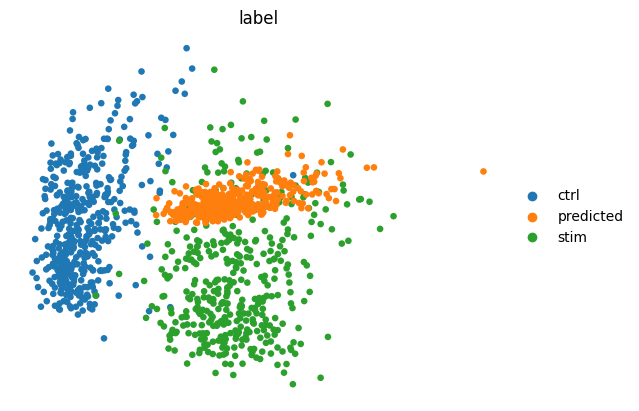

PCA plot created.



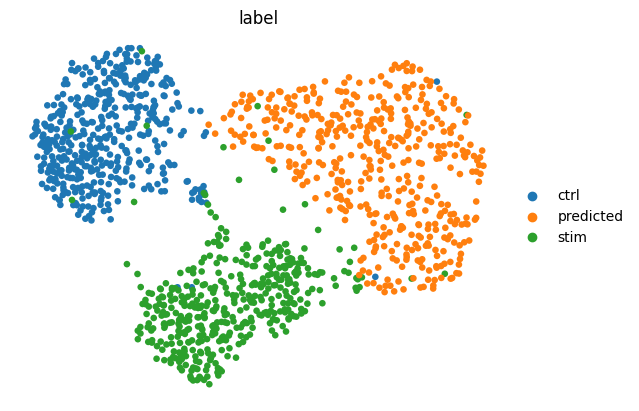

UMAP plot created.



/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



--- CD4 T cells shared DEGs: ['CCL8', 'CXCL10', 'LAG3']
  celltype_to_predict        Type  dist_scaled  mean_var_distn  lfc_corr  \
0         CD4 T cells   all genes     0.724310        0.001782       NaN   
1         CD4 T cells  top100DEGs     0.538324        0.008712  0.995313   

   jaccard_topK   R2_mean    R2_std  MSE_mean   MSE_std  ...  Pearson_mean  \
0           NaN  0.875944  0.003376  0.001587  0.000052  ...      0.944985   
1      0.015228  0.655652  0.009997  0.038526  0.001825  ...      0.869875   

   Pearson_std  Cosine_mean  Cosine_std  Edist_mean  Edist_std  MMD_mean  \
0     0.001989     0.946902    0.001913    2.858892   0.051940  0.401989   
1     0.004572     0.935965    0.002309    2.071997   0.059772  0.624742   

    MMD_std  Euc_mean   Euc_std  
0  0.015966  2.775588  0.047694  
1  0.016647  1.949802  0.047025  

[2 rows x 26 columns]


/tmp/ipykernel_509591/406436112.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time":     datetime.utcnow().isoformat()+"Z",


In [13]:
import time, psutil, json
from datetime import datetime
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse, stats
from scipy.spatial.distance import cosine as cosine_dist, cdist
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
# and of course import your scGenPerturbationAnalysis
# from your_module import scGenPerturbationAnalysis

# -----------------------------------------------------------------------------
# 0) resource‐snapshotting
# -----------------------------------------------------------------------------
try:
    import GPUtil
    def snapshot_gpus():
        return [
            {"id": g.id,
             "load_pct":    g.load*100,
             "mem_used_MB": g.memoryUsed,
             "mem_free_MB": g.memoryFree}
            for g in GPUtil.getGPUs()
        ]
except ImportError:
    def snapshot_gpus(): return []

_monitor = []
def take_snapshot(stage:str):
    proc = psutil.Process()
    _monitor.append({
      "time":     datetime.utcnow().isoformat()+"Z",
      "stage":    stage,
      "cpu_pct":  psutil.cpu_percent(interval=None),
      "proc_cpu": proc.cpu_percent(interval=None),
      "ram_MB":   proc.memory_info().rss/1024**2,
      "gpus":     snapshot_gpus(),
    })

# -----------------------------------------------------------------------------
# 1) helpers: mean–var KDE, bootstrap, scaled‐Euclidean
# -----------------------------------------------------------------------------
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1 = np.vstack([m1, v1]).T
    pts2 = np.vstack([m2, v2]).T
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T
    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum() * dx * dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca,
                      n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
    rng = np.random.default_rng(random_seed)
    real_idx = np.where(real_mask)[0]
    pred_idx = np.where(pred_mask)[0]
    s_r = max(1, int(frac*len(real_idx)))
    s_p = max(1, int(frac*len(pred_idx)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}
    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y
        # errors
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))
        # correlations
        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1-cosine_dist(Xp, Y))
        # R²
        ss_res = ((Y-Xp)**2).sum()
        ss_tot = ((Y-Y.mean())**2).sum()
        vals["R2"].append(1-ss_res/ss_tot if ss_tot>0 else np.nan)
        # PCA‐space distances
        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0)-Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean()-d_rr.mean()-d_pp.mean())
        Krr = np.exp(-cdist(Pr,Pr,'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp,Pp,'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr,Pp,'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean()+Kpp.mean()-2*Krp.mean())
    def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
    out={}
    for k in keys:
        m,s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"]  = s
    return out

def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(0)
    m_pert = X[pert_mask].mean(0)
    m_pred = X[pred_mask].mean(0)
    ok = (~np.isnan(m_ctrl) & ~np.isnan(m_pert) & ~np.isnan(m_pred))
    d_in = np.linalg.norm(m_ctrl[ok]-m_pert[ok])
    d_pr = np.linalg.norm(m_pred[ok]-m_pert[ok])
    return d_pr/(d_in+eps)

# -----------------------------------------------------------------------------
# 2) set up & run
# -----------------------------------------------------------------------------
take_snapshot("START")
condition_col  = "label"
celltype_col   = "cell_type"
ctrl_key       = "ctrl"
stim_key       = "stim"
common_celltypes = ["CD4 T cells"]
K              = 100
pca_components = 20
results = []

for celltype in common_celltypes:
    # — preprocess
    take_snapshot("before_preprocess")
    an = scGenPerturbationAnalysis(norm_data)
    an.preprocess_data(highly_variable_genes=False,
                       n_top_genes=norm_data.n_vars)
    take_snapshot("after_preprocess")

    # — train split & model
    an.prepare_training_set(
      exclude_query=f'{celltype_col}=="{celltype}" & {condition_col}=="{stim_key}"'
    )
    an.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
    take_snapshot("before_train")
    an.train_model(max_epochs=n_epochs,
                   batch_size=batch_size,
                   accelerator="gpu", devices=1)
    take_snapshot("after_train")

    # — predict & eval
    take_snapshot("before_predict")
    an.make_prediction(
      ctrl_key=ctrl_key, stim_key=stim_key,
      celltype_to_predict=celltype,
      condition_col=condition_col,
      cell_type_col=celltype_col
    )
    take_snapshot("after_predict")
    take_snapshot("before_eval")
    an.evaluate_prediction(
      condition_col=condition_col,
      cell_type_col=celltype_col,
      control_condition=ctrl_key,
      stimulated_condition=stim_key,
      celltype_to_evaluate=celltype,
      pca_components=pca_components
    )
    take_snapshot("after_eval")

    # — gather & compute metrics exactly as before —
    ad = an.eval_adata[
      an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
    ].copy()
    ad.obs.rename({condition_col:"condition"}, axis=1, inplace=True)
    X_full    = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
    Xpca_full = ad.obsm["X_pca"]
    ctrl_m    = ad.obs["condition"]==ctrl_key
    pert_m    = ad.obs["condition"]==stim_key
    pred_m    = ad.obs["condition"]=="predicted"

    sc.tl.rank_genes_groups(ad,
        groupby="condition",reference=ctrl_key,
        groups=[stim_key,"predicted"],method="wilcoxon",n_genes=ad.n_vars
    )
    rg    = ad.uns["rank_genes_groups"]
    names = rg["names"]
    lfcs  = rg["logfoldchanges"]
    de_genes = list(names[stim_key][:K])

    for label,(X,Xpca) in [
      ("all genes",(X_full,Xpca_full)),
      ("top100DEGs",(
        X_full[:,[ad.var_names.get_loc(g) for g in de_genes]],
        PCA(pca_components).fit_transform(
          X_full[:,[ad.var_names.get_loc(g) for g in de_genes]]
        )
      ))
    ]:
        boot          = bootstrap_metrics(X,pert_m,pred_m,Xpca)
        dist_scaled   = compute_dist_scaled(X,ctrl_m,pert_m,pred_m)
        mean_var_dist = mean_var_kde_distance(X[pert_m],X[pred_m])

        if label=="top100DEGs":
            pred_top = list(names["predicted"][:K])
            shared   = set(de_genes)&set(pred_top)
            print(f"\n--- {celltype} shared DEGs: {sorted(shared)}")
            if shared:
                lfc_t = [lfcs[stim_key][names[stim_key].tolist().index(g)] for g in shared]
                lfc_p = [lfcs["predicted"][names["predicted"].tolist().index(g)] for g in shared]
                lfc_corr = np.corrcoef(lfc_t,lfc_p)[0,1] if len(shared)>1 else np.nan
            else:
                lfc_corr = np.nan
            jacc = len(shared)/(2*K-len(shared))
        else:
            lfc_corr,jacc = np.nan,np.nan

        row = {
          "celltype_to_predict":celltype,"Type":label,
          "dist_scaled":dist_scaled,
          "mean_var_distn":mean_var_dist,
          "lfc_corr":lfc_corr,"jaccard_topK":jacc,
          **boot
        }
        results.append(row)

take_snapshot("END")

# — write usage log & results —
with open("usage_log.json","w") as f:
    json.dump(_monitor, f, indent=2)

results_df = pd.DataFrame(results)
results_df.to_csv("scgen_tutorial.csv",index=False)
print(results_df)


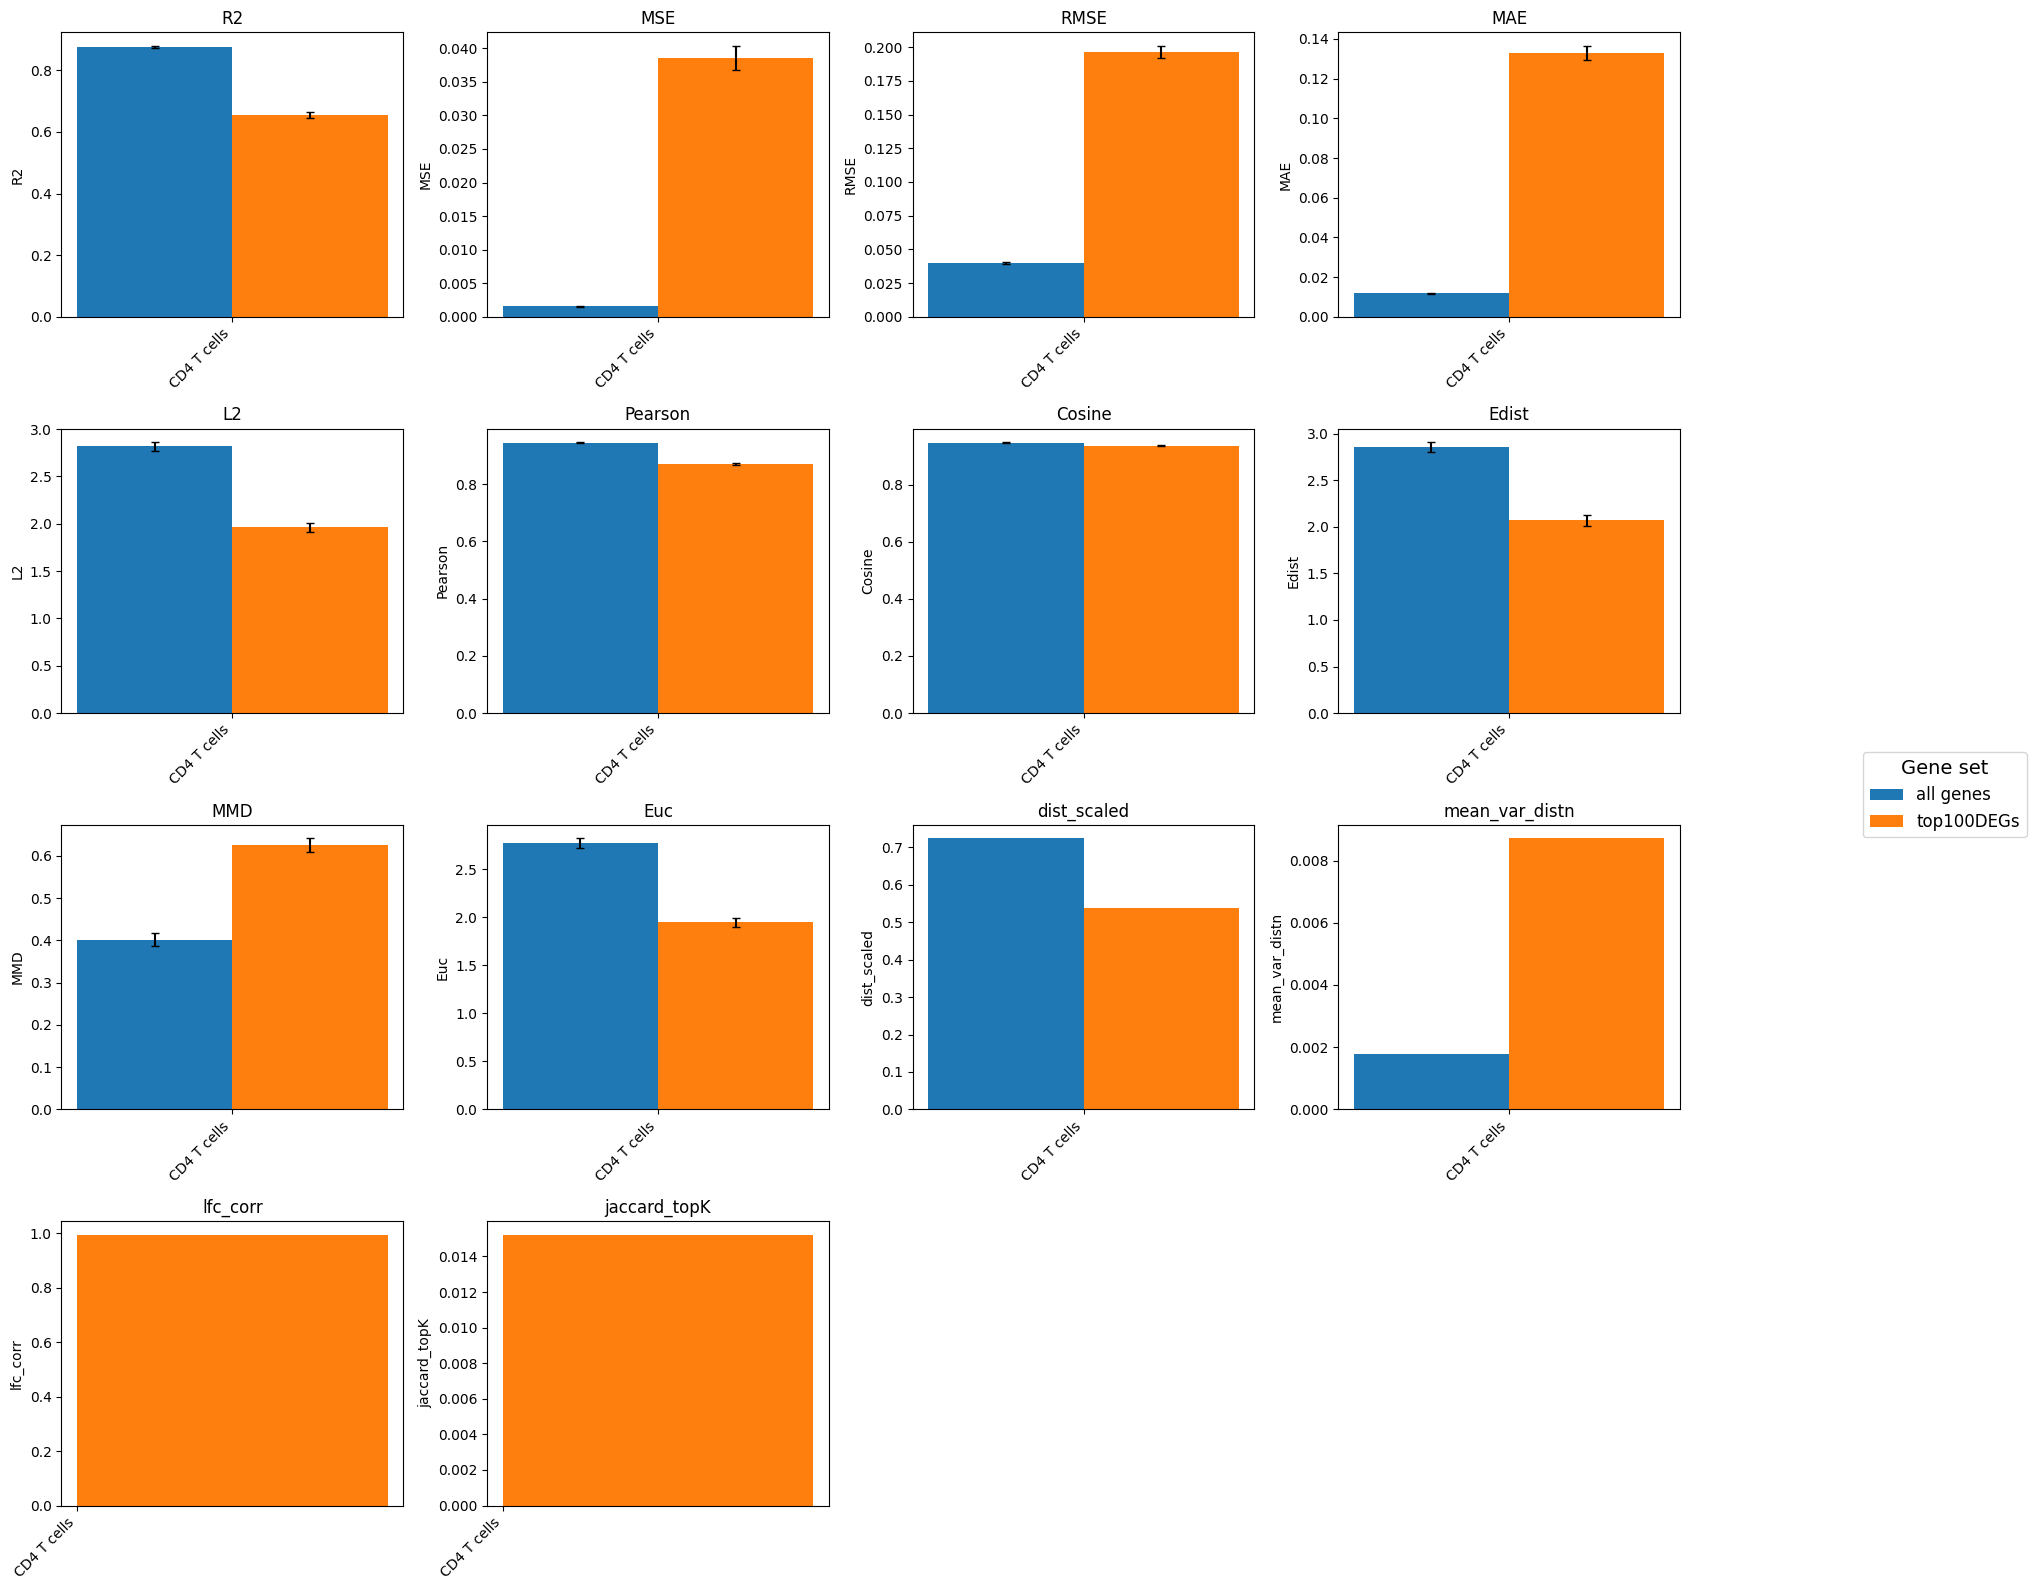

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# list all the paired mean/std columns you care about, plus single‐value metrics
metrics = [
    ("R2_mean",        "R2_std"),
    ("MSE_mean",       "MSE_std"),
    ("RMSE_mean",      "RMSE_std"),
    ("MAE_mean",       "MAE_std"),
    ("L2_mean",        "L2_std"),
    ("Pearson_mean",   "Pearson_std"),
    ("Cosine_mean",    "Cosine_std"),
    ("Edist_mean",     "Edist_std"),
    ("MMD_mean",       "MMD_std"),
    ("Euc_mean",       "Euc_std"),
    ("dist_scaled",    None),         # single‐value metric
    ("mean_var_distn", None),         # single‐value metric
    ("lfc_corr",       None),
    ("jaccard_topK",   None),
]

cell_types = results_df["celltype_to_predict"].unique()
gene_sets  = results_df["Type"].unique()

n = len(metrics)
cols = 4
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
axes = axes.ravel()

x = np.arange(len(cell_types))
width = 0.35

for ax, (mean_col, std_col) in zip(axes, metrics):
    for i, gs in enumerate(gene_sets):
        sub = results_df[results_df["Type"]==gs].set_index("celltype_to_predict")
        y = sub[mean_col].reindex(cell_types)
        yerr = sub[std_col].reindex(cell_types) if std_col else None

        ax.bar(
            x + (i-0.5)*width,
            y.values,
            width,
            yerr=(yerr.values if yerr is not None else None),
            capsize=3,
            label=gs
        )

    ax.set_xticks(x)
    ax.set_xticklabels(cell_types, rotation=45, ha="right")
    ax.set_title(mean_col.replace("_mean",""), fontsize=12)
    ax.set_ylabel(mean_col if std_col is None else mean_col.replace("_mean",""), fontsize=10)

# --- NEW: turn off any extra subplots ---
for ax in axes[len(metrics):]:
    ax.axis('off')

# Deduplicate legend
handles, labels = axes[0].get_legend_handles_labels()
unique = OrderedDict(zip(labels, handles))
fig.legend(
    unique.values(), unique.keys(),
    loc="center right", bbox_to_anchor=(1.02, 0.5),
    title="Gene set", fontsize=12, title_fontsize=14
)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()


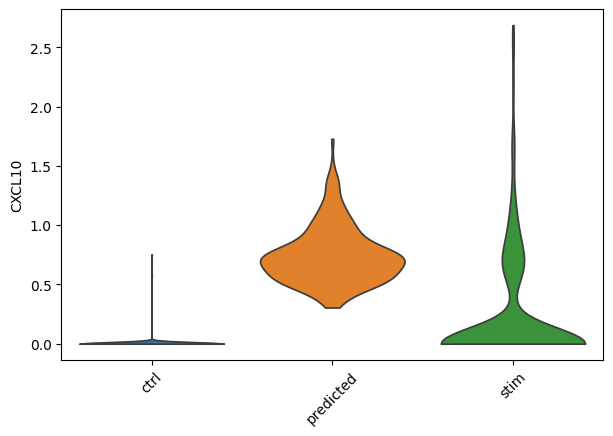

<Figure size 640x480 with 0 Axes>

In [15]:
import scanpy as sc
import matplotlib.pyplot as plt

# 1) pick your gene and cell-type
gene     = "CXCL10"         # or ["CCL8","CXCL10"] for multiple
celltype = "CD4 T cells"  # or None for all

# 2) pull out your eval AnnData
adata = an.eval_adata.copy()

# 3) (optional) restrict to one cell-type
if celltype is not None:
    adata = adata[adata.obs["cell_type"] == celltype].copy()

# 4) call Scanpy’s violin (no title kw here)
sc.pl.violin(
    adata,
    keys=gene,
    groupby="label",
    order=["ctrl", "predicted", "stim"],  # <-- use "predicted" here
    stripplot=False,
    jitter=0.3,
    rotation=45,
)


# 5) now grab the figure and set the title yourself
plt.gcf().suptitle(f"{celltype or 'all cell-types'} • {gene}", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
# --- at the very end of your script ---
# re‐create the Process handle
proc = psutil.Process()

end = time.perf_counter()
end_dt = datetime.now().isoformat()
final = {
    "timestamp": end_dt,
    "elapsed_seconds": end - _start_time,
    "cpu_percent": psutil.cpu_percent(interval=None),
    "proc_cpu_percent": proc.cpu_percent(interval=None),
    "ram_used_MB": proc.memory_info().rss / (1024**2),
    "gpus": [
        {
            "id": g.id,
            "load": g.load,
            "memoryUtil": g.memoryUtil,
            "memoryFree": g.memoryFree,
            "memoryUsed": g.memoryUsed
        } for g in GPUtil.getGPUs()
    ]
}
print("END:  ", json.dumps(final, indent=2))

END:   {
  "timestamp": "2025-05-01T08:42:25.738571",
  "elapsed_seconds": 60.77508248575032,
  "cpu_percent": 12.8,
  "proc_cpu_percent": 0.0,
  "ram_used_MB": 2330.42578125,
  "gpus": [
    {
      "id": 0,
      "load": 0.0,
      "memoryUtil": 0.04147135416666667,
      "memoryFree": 14279.0,
      "memoryUsed": 637.0
    }
  ]
}


Sample GPU entry keys: [{'id': 0, 'load_pct': 0.0, 'mem_used_MB': 1.0, 'mem_free_MB': 14916.0}]
                        time_s              stage  cpu_pct  proc_cpu  \
0  2025-05-01T08:41:35.807706Z              START      3.1       0.0   
1  2025-05-01T08:41:35.838662Z  before_preprocess      4.0       0.0   
2  2025-05-01T08:41:35.885594Z   after_preprocess      2.7       0.0   
3  2025-05-01T08:41:35.930615Z       before_train      2.8       0.0   
4  2025-05-01T08:42:07.584320Z        after_train      3.5       0.0   

        ram_MB  gpu_load_pct gpu_mem_used  
0  1228.152344             0         None  
1  1228.152344             0         None  
2  1238.937500             0         None  
3  1234.812500             0         None  
4  2287.675781             0         None  


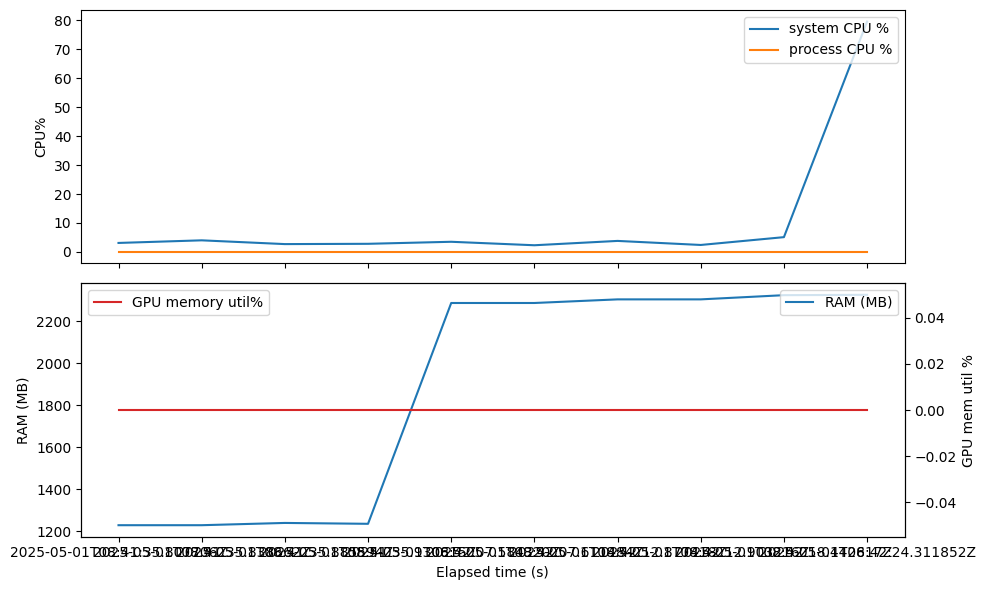

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the log
with open("usage_log.json") as f:
    data = json.load(f)

# 2) Inspect one GPU record to confirm available keys
print("Sample GPU entry keys:", data[0]["gpus"])
# should print something like: [{'id': 0, 'memoryUtil': 0.34, 'memoryUsed_MB': 3210, ...}]

# 3) Build DataFrame
rows = []
for rec in data:
    base = {
        "time_s":   rec["time"],
        "stage":    rec["stage"],
        "cpu_pct":  rec["cpu_pct"],
        "proc_cpu": rec["proc_cpu"],
        "ram_MB":   rec["ram_MB"],
    }
    # if there's at least one GPU record
    if rec["gpus"]:
        g = rec["gpus"][0]
        base.update({
            # memoryUtil is 0–1 fraction; convert to %
            "gpu_load_pct":   g.get("memoryUtil", 0) * 100,
            # memoryUsed_MB is already in MB
            "gpu_mem_used":   g.get("memoryUsed_MB", None),
        })
    rows.append(base)

df = pd.DataFrame(rows)
print(df.head())

# 4) Plot system vs process CPU, RAM, and GPU usage
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# CPU panel
ax1.plot(df["time_s"], df["cpu_pct"],  label="system CPU %")
ax1.plot(df["time_s"], df["proc_cpu"], label="process CPU %")
ax1.set_ylabel("CPU%")
ax1.legend(loc="upper right")

# RAM & GPU panel
ax2.plot(df["time_s"], df["ram_MB"], label="RAM (MB)")
ax2.set_ylabel("RAM (MB)")
if "gpu_load_pct" in df:
    ax2b = ax2.twinx()
    ax2b.plot(df["time_s"], df["gpu_load_pct"], color="C3", label="GPU memory util%")
    ax2b.set_ylabel("GPU mem util %")
    ax2b.legend(loc="upper left")

ax2.set_xlabel("Elapsed time (s)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


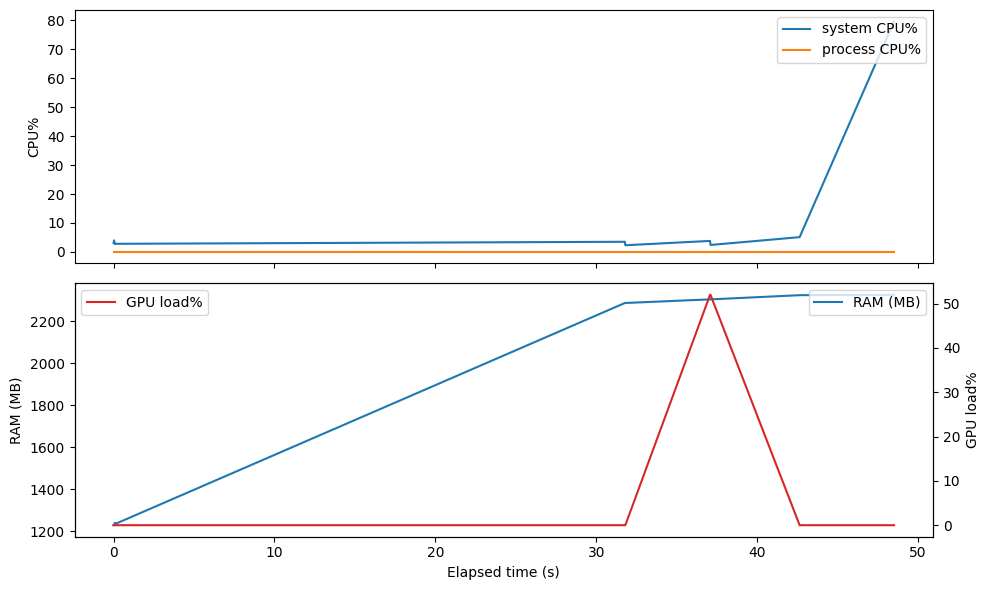

In [18]:
import json, pandas as pd, matplotlib.pyplot as plt

# 1) load
with open("usage_log.json") as f:
    data = json.load(f)

# 2) normalize
rows = []
for rec in data:
    base = {
        "time_s":   rec["time"],
        "stage":    rec["stage"],
        "cpu_pct":  rec["cpu_pct"],
        "proc_cpu": rec["proc_cpu"],
        "ram_MB":   rec["ram_MB"],
    }
    if rec["gpus"]:
        g = rec["gpus"][0]
        base.update({
            "gpu_load_pct": g["load_pct"],
            "gpu_mem_used": g["mem_used_MB"],
        })
    rows.append(base)

df = pd.DataFrame(rows)

# 3) compute elapsed seconds
df["time_dt"]   = pd.to_datetime(df["time_s"])
df["elapsed_s"] = (df["time_dt"] - df["time_dt"].iloc[0]).dt.total_seconds()

# 4) plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

ax1.plot(df["elapsed_s"], df["cpu_pct"],  label="system CPU%")
ax1.plot(df["elapsed_s"], df["proc_cpu"], label="process CPU%")
ax1.set_ylabel("CPU%")
ax1.legend(loc="upper right")

ax2.plot(df["elapsed_s"], df["ram_MB"], label="RAM (MB)")
ax2.set_ylabel("RAM (MB)")

if "gpu_load_pct" in df:
    ax2b = ax2.twinx()
    ax2b.plot(df["elapsed_s"], df["gpu_load_pct"], color="C3", label="GPU load%")
    ax2b.set_ylabel("GPU load%")
    ax2b.legend(loc="upper left")

ax2.set_xlabel("Elapsed time (s)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()
